# Linear Regression Work for Campaign 4

### Import Necessary Packages

In [1]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np
import itertools
import pandas as pd
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from pathlib import Path
from typing import List, Optional, Literal, Dict, Any
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list
from scipy.spatial.distance import pdist, squareform
from scipy.stats import pearsonr
from __future__ import annotations
from pathlib import Path
from typing import Any, Dict, List, Optional, Literal
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list, optimal_leaf_ordering

### Functions for carrying out linear regression

In [2]:
def evaluate_combinations(data, descriptors, output_var, log_output=False, normalize=False, limit_descriptor_number=None):
    # List to store results
    results = []

    # Determine the maximum number of descriptors allowed
    max_descriptors = limit_descriptor_number if limit_descriptor_number is not None else len(descriptors)

    # Loop through all possible combinations of descriptors within the limit
    for r in range(1, min(len(descriptors), max_descriptors) + 1):
        for combination in itertools.combinations(descriptors, r):
            X = data[list(combination)].values
            y = data[output_var].values

            if normalize:
                from sklearn.preprocessing import MinMaxScaler
                scaler = MinMaxScaler()
                X = scaler.fit_transform(X)

            if log_output:
                y = np.log10(y)

            # Train the model
            model = LinearRegression()
            model.fit(X, y)
            y_pred = model.predict(X)
            r2 = r2_score(y, y_pred)
            
            # Append results to list
            results.append({
                'Descriptors': combination,
                'Number of Descriptors': len(combination),
                'R²': r2
            })

    # Create a DataFrame from the results list
    results_df = pd.DataFrame(results)

    # Sort the DataFrame by R² in descending order
    results_df = results_df.sort_values(by='R²', ascending=False)

    # Print the results
    print(f"R² Results for each combination of descriptors (max {max_descriptors} descriptors):")
    print(results_df)

    return results_df


In [3]:
def evaluate_combinations_with_coeffs(
    data: pd.DataFrame,
    descriptors: list,
    output_var: str,
    log_output: bool = False,
    normalize: bool = False,
    limit_descriptor_number: int | None = None,
    top_n: int | None = None,
    min_rows_per_model: int | None = None,   # None -> auto: len(combination) + 1 if intercept
) -> pd.DataFrame:
    """
    Enumerate all combinations of the given descriptors (up to 'limit_descriptor_number'),
    call `run_linear_regression(..., plot=False)` for each combination, and return a
    DataFrame ranked by R² that includes the Intercept and per-descriptor coefficients.

    Columns returned (among others):
      - 'Descriptors (tuple)'
      - 'Number of Descriptors'
      - 'Intercept'
      - 'R²'
      - 'Descriptor 1', 'Descriptor 1 coefficient', ..., up to max_k

    Models with fewer descriptors than the maximum will have NaN in the extra columns.
    """
    results = []

    # Max number of descriptors to try in each combination
    max_descriptors = limit_descriptor_number if limit_descriptor_number is not None else len(descriptors)

    # Prepare y for masking (convert to numeric and check positivity if log requested)
    y_series = pd.to_numeric(data[output_var], errors="coerce")
    if log_output and (y_series <= 0).any():
        raise ValueError(f"log_output=True but non-positive values found in '{output_var}'.")

    # Whether to include label column if present
    label_col = 'Solvent' if 'Solvent' in data.columns else None

    for r in range(1, min(len(descriptors), max_descriptors) + 1):
        for combination in itertools.combinations(descriptors, r):
            # Convert selected X columns to numeric; mask rows with complete data for this combo + y
            X_sub = data[list(combination)].apply(pd.to_numeric, errors="coerce")
            mask = X_sub.notna().all(axis=1) & y_series.notna()

            n_rows = int(mask.sum())
            needed = (r + 1) if min_rows_per_model is None else int(min_rows_per_model)
            if n_rows < max(needed, 2):
                # Not enough rows to fit or compute R²
                continue

            # Build a filtered frame containing only what run_linear_regression needs
            keep_cols = list(combination) + [output_var]
            if label_col:
                keep_cols.append(label_col)
            df_sub = data.loc[mask, keep_cols].copy()

            # Fit via the shared function (no plotting / no verbose spam during sweep)
            model, r2 = run_linear_regression(
                data=df_sub,
                descriptors=list(combination),
                output_var=output_var,
                log_output=log_output,
                normalize=normalize,
                plot=False,
                verbose=False,
                label_col=label_col if label_col else 'Solvent'  # won't be used if missing
            )

            results.append({
                "Descriptors (tuple)": tuple(combination),
                "Number of Descriptors": r,
                "Intercept": float(model.intercept_),
                "R²": float(r2),
                "_desc_names": list(combination),
                "_coef_vals": [float(c) for c in model.coef_],
            })

    # If nothing fitted, return empty df
    if not results:
        return pd.DataFrame(columns=[
            "Descriptors (tuple)", "Number of Descriptors", "Intercept", "R²"
        ])

    results_df = pd.DataFrame(results).sort_values(by="R²", ascending=False).reset_index(drop=True)

    # Apply top_n if requested
    if top_n is not None:
        results_df = results_df.head(top_n).copy()

    # Decide how many descriptor/coef columns to expose
    max_k = limit_descriptor_number if limit_descriptor_number is not None else int(results_df["Number of Descriptors"].max())

    # Expand descriptor names and coefficients into clear columns, padding with NaN
    for i in range(max_k):
        name_col = f"Descriptor {i+1}"
        coef_col = f"Descriptor {i+1} coefficient"
        results_df[name_col] = results_df["_desc_names"].apply(lambda lst: lst[i] if i < len(lst) else np.nan)
        results_df[coef_col] = results_df["_coef_vals"].apply(lambda lst: lst[i] if i < len(lst) else np.nan)

    # Order columns nicely
    base_cols = ["Descriptors (tuple)", "Number of Descriptors", "Intercept", "R²"]
    expanded_cols = []
    for i in range(max_k):
        expanded_cols += [f"Descriptor {i+1}", f"Descriptor {i+1} coefficient"]

    final_cols = base_cols + expanded_cols
    results_df = results_df[final_cols]

    return results_df


In [4]:
def run_linear_regression(data, descriptors, output_var, log_output=False, normalize=False, figsize=(8, 6), annotation_datapoint_separation=1):
    X = data[descriptors].values
    y = data[output_var].values
    labels = data['Solvent'].values  
    print('X',X)
    if normalize:
        scaler = MinMaxScaler()
        X = scaler.fit_transform(X)
        #print('normalised X',X)
    print(X)
    if log_output:
        y = np.log10(y)

    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)

    # Plotting
    plt.figure(figsize=figsize)
    if X.shape[1] == 1:
        plt.scatter(X, y, color='blue', label='Actual')
        plt.plot(X, y_pred, color='red', label='Predicted')
        # Annotate points with separation scaling
        for xi, yi, label in zip(X, y, labels):
            plt.annotate(label, (xi[0] + annotation_datapoint_separation * 0.05, yi + annotation_datapoint_separation * 0.05), fontsize=8, alpha=0.8)
        eqn = f"y = {model.coef_[0]:.4f}x + {model.intercept_:.4f}"
        plt.title(f'Linear Regression\n{eqn}, R² = {r2:.4f}')
        plt.xlabel(descriptors[0])
        plt.ylabel(f'log10({output_var})' if log_output else output_var)
    else:
        plt.scatter(y, y_pred, color='green')
        # Annotate points with separation scaling
        for yi, ypi, label in zip(y, y_pred, labels):
            plt.annotate(label, (yi + annotation_datapoint_separation * 0.05, ypi + annotation_datapoint_separation * 0.05), fontsize=8, alpha=0.8)
        plt.plot([min(y), max(y)], [min(y), max(y)], 'r--', label='Ideal Fit')
        plt.title(f'Predicted vs Actual\nR² = {r2:.4f}')
        plt.xlabel(f'Actual {"log10(" + output_var + ")" if log_output else output_var}')
        plt.ylabel('Predicted')

    plt.legend()
    plt.tight_layout()
    plt.show()

    # Print results
    print("Regression Coefficients:")
    for d, coef in zip(descriptors, model.coef_):
        print(f"{d}: {coef:.4f}")
    print(f"Intercept: {model.intercept_:.4f}")
    print(f"R²: {r2:.4f}")

    return model, r2

In [5]:
def run_linear_regression(
    data,
    descriptors,
    output_var,
    log_output=False,
    normalize=False,
    plot=True,
    figsize=(8, 6),
    annotation_datapoint_separation=1,
    label_col='Solvent',
    verbose=True,
    annotate_equation=False,
    annotation_fontsize=10,
    title=True
):
    """
    Fit a linear regression model. Optionally plot and/or transform data.

    Parameters
    ----------
    annotate_equation : bool
        If True, annotate the plot with the fitted regression equation
        using the actual descriptor names and numeric coefficients,
        plus the R² underneath.
    annotation_fontsize : int
        Font size for the annotation text.

    Returns
    -------
    model : LinearRegression
    r2    : float
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import r2_score

    X = data[descriptors].values
    y = data[output_var].values
    labels = data[label_col].values if label_col in data.columns else None

    if normalize:
        scaler = MinMaxScaler()
        X = scaler.fit_transform(X)

    if log_output:
        y = np.log10(y)

    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)

    # Build equation text with numeric coefficients and actual descriptor names
    def _build_equation_annotation(intercept, coefs, desc_names):
        # y = C (+/- a*desc1) (+/- b*desc2) ...
        terms = [f"{intercept:.4f}"]
        for name, coef in zip(desc_names, coefs):
            sign = "+" if coef >= 0 else "-"
            terms.append(f" {sign} {abs(coef):.4f}*{name}")
        eqn = "y = " + "".join(terms)
        return eqn + f"\nR² = {r2:.4f}"

    if plot:
        plt.figure(figsize=figsize)
        if X.shape[1] == 1:
            x = X[:, 0]
            idx = np.argsort(x)
            plt.scatter(x, y, label="Actual")
            plt.plot(x[idx], y_pred[idx], "r--", label="Predicted")
            if labels is not None:
                for xi, yi, lab in zip(X, y, labels):
                    plt.annotate(
                        lab,
                        (xi[0] + annotation_datapoint_separation * 0.05,
                         yi + annotation_datapoint_separation * 0.05),
                        fontsize=8,
                        alpha=0.8
                    )
            eqn = f"y = {model.coef_[0]:.4f}x + {model.intercept_:.4f}"
            if title!=False:
                if title==True:
                    plt.title(f'Predicted vs Actual\nR² = {r2:.4f}')
                else:
                    plt.title(title)
            plt.xlabel(descriptors[0])
            plt.ylabel(f'log10({output_var})' if log_output else output_var)
        else:
            plt.scatter(y, y_pred, label='Predicted vs Actual')
            if labels is not None:
                for yi, ypi, lab in zip(y, y_pred, labels):
                    plt.annotate(
                        lab,
                        (yi + annotation_datapoint_separation * 0.05,
                         ypi + annotation_datapoint_separation * 0.05),
                        fontsize=8,
                        alpha=0.8
                    )
            lo, hi = float(np.min(y)), float(np.max(y))
            plt.plot([lo, hi], [lo, hi], 'r--', label='Ideal Fit')
            if title!=False:
                if title==True:
                    plt.title(f'Predicted vs Actual\nR² = {r2:.4f}')
                else:
                    plt.title(title)
            plt.xlabel(f'Actual {"log10(" + output_var + ")" if log_output else output_var}')
            plt.ylabel('Predicted')

        # Corner annotation (no color changes) with descriptor names
        if annotate_equation:
            ann_text = _build_equation_annotation(model.intercept_, model.coef_, descriptors)
            ax = plt.gca()
            ax.text(
                0.02, 0.98, ann_text,
                transform=ax.transAxes,
                va='top', ha='left',
                fontsize=annotation_fontsize,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8, edgecolor='none')
            )

        plt.legend()
        plt.tight_layout()
        plt.show()

    if verbose:
        print("Regression Coefficients:")
        for d, coef in zip(descriptors, model.coef_):
            print(f"{d}: {coef:.4f}")
        print(f"Intercept: {model.intercept_:.4f}")
        print(f"R²: {r2:.4f}")

    return model, r2


### Function for Sorting the Results DF by Number of Descriptors

In [6]:
import pandas as pd

def filter_models_by_n(df: pd.DataFrame, number_descriptors: int, top_n: int = None) -> pd.DataFrame:
    """
    Filter models by the specified number of descriptors and rank by R².

    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe with at least the columns:
        - 'Descriptors'
        - 'Number of Descriptors'
        - 'R²'
    number_descriptors : int
        Desired number of descriptors to filter on.
    top_n : int or None, default=None
        If provided, return only the top N models ranked by R².
        If None, return all models with the given number of descriptors.

    Returns
    -------
    pd.DataFrame
        Filtered dataframe containing only models with the given number of
        descriptors, sorted by R² descending.
    """
    # Clean column names
    df = df.rename(columns=lambda x: x.strip())

    # Filter
    df_filt = df[df["Number of Descriptors"] == number_descriptors].copy()

    # Sort by R² descending
    df_filt = df_filt.sort_values(by="R²", ascending=False).reset_index(drop=True)

    # Optionally limit to top_n
    if top_n is not None:
        df_filt = df_filt.head(top_n)

    return df_filt


### Adjust Settings for Displaying Pandas Dataframes

In [7]:
# Adjust display settings to show all rows and columns
pd.set_option('display.max_rows', None) 
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)  
pd.set_option('display.max_colwidth', None) 

## Linear Regression Work

### Load solvent data

In [8]:
data_C4 = pd.read_excel('SAKE C4 Kk2 Kk3 and descriptors.xlsx')
descriptors=list(data_C4.columns)[1:-4]

### Evaluation of models for Pathway A (Kk2) 

In [9]:
sorted_r2_results_Kk2 = evaluate_combinations_with_coeffs(
    data_C4,
    descriptors=descriptors,
    output_var="Kk2 / M-1s-1",
    log_output=True,
    normalize=True,
    limit_descriptor_number=4,
)

#### Visualisation of best models for different number of descriptors

In [10]:
sorted_r2_results_Kk2.head(25)

,Descriptors (tuple),Number of Descriptors,Intercept,R²,Descriptor 1,Descriptor 1 coefficient,Descriptor 2,Descriptor 2 coefficient,Descriptor 3,Descriptor 3 coefficient,Descriptor 4,Descriptor 4 coefficient
0,"(SP, πKT, SB, δP)",4,-4.229376,0.897427,SP,1.886036,πKT,-1.564513,SB,0.359418,δP,0.845876
1,"(βA, μ, SP, SB)",4,-4.244233,0.895005,βA,-2.018329,μ,-1.215692,SP,3.502535,SB,1.783402
2,"(βA, SP, SB, δD)",4,-4.974336,0.894446,βA,-3.556145,SP,2.819298,SB,2.842133,δD,1.385911
3,"(βA, SP, πKT, δP)",4,-4.220024,0.893606,βA,0.533950,SP,1.441105,πKT,-1.745592,δP,1.207407
4,"(βA, SP, βKT, SPP)",4,-3.952810,0.893247,βA,-1.140061,SP,2.223782,βKT,1.156695,SPP,-0.999479
5,"(SP, βKT, πKT, δP)",4,-4.115302,0.892613,SP,1.750708,βKT,0.244063,πKT,-1.443032,δP,0.738726
6,"(SP, βKT, SPP, δP)",4,-4.313295,0.889790,SP,1.031411,βKT,0.818422,SPP,-1.195728,δP,1.140184
7,"(SP, πKT, δP, δH)",4,-4.143310,0.888384,SP,1.841179,πKT,-1.366402,δP,0.664340,δH,0.281359
8,"(ε, SP, δP, δH)",4,-4.608965,0.885049,ε,-2.028725,SP,1.661841,δP,1.788400,δH,1.133952
9,"(βA, SP, SPP, SB)",4,-4.456939,0.883450,βA,-1.918643,SP,3.309235,SPP,-1.126953,SB,2.119930


In [11]:
filter_models_by_n(sorted_r2_results_Kk2,1).head(10)

,Descriptors (tuple),Number of Descriptors,Intercept,R²,Descriptor 1,Descriptor 1 coefficient,Descriptor 2,Descriptor 2 coefficient,Descriptor 3,Descriptor 3 coefficient,Descriptor 4,Descriptor 4 coefficient
0,"(ε,)",1,-4.188394,0.671109,ε,1.173062,NaN,NaN,NaN,NaN,NaN,NaN
1,"(SP,)",1,-4.056458,0.668169,SP,1.050491,NaN,NaN,NaN,NaN,NaN,NaN
2,"(δP,)",1,-4.198000,0.617460,δP,1.201507,NaN,NaN,NaN,NaN,NaN,NaN
3,"(μ,)",1,-4.191106,0.529306,μ,0.981616,NaN,NaN,NaN,NaN,NaN,NaN
4,"(SPP,)",1,-4.204087,0.527618,SPP,1.034806,NaN,NaN,NaN,NaN,NaN,NaN
5,"(πKT,)",1,-4.085485,0.445923,πKT,0.949998,NaN,NaN,NaN,NaN,NaN,NaN
6,"(γ ,)",1,-3.983197,0.353660,γ,0.960670,NaN,NaN,NaN,NaN,NaN,NaN
7,"(DN,)",1,-3.948434,0.285317,DN,0.820514,NaN,NaN,NaN,NaN,NaN,NaN
8,"(βA,)",1,-4.060503,0.277932,βA,0.843850,NaN,NaN,NaN,NaN,NaN,NaN
9,"(βKT,)",1,-3.908166,0.180063,βKT,0.572349,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
filter_models_by_n(sorted_r2_results_Kk2,2).head(10)

,Descriptors (tuple),Number of Descriptors,Intercept,R²,Descriptor 1,Descriptor 1 coefficient,Descriptor 2,Descriptor 2 coefficient,Descriptor 3,Descriptor 3 coefficient,Descriptor 4,Descriptor 4 coefficient
0,"(αA, SP)",2,-4.294936,0.798390,αA,0.496207,SP,1.345685,NaN,NaN,NaN,NaN
1,"(SP, αKT)",2,-4.267046,0.783593,SP,1.306292,αKT,0.502239,NaN,NaN,NaN,NaN
2,"(SP, δH)",2,-4.313387,0.783439,SP,1.179032,δH,0.546014,NaN,NaN,NaN,NaN
3,"(SP, AN)",2,-4.278207,0.782267,SP,1.168256,AN,0.508967,NaN,NaN,NaN,NaN
4,"(ET, SP)",2,-4.262382,0.777428,ET,0.513322,SP,1.006267,NaN,NaN,NaN,NaN
5,"(SP, πKT)",2,-3.870064,0.773754,SP,2.267965,πKT,-1.424805,NaN,NaN,NaN,NaN
6,"(SP, SA)",2,-4.223381,0.764562,SP,1.207195,SA,0.488900,NaN,NaN,NaN,NaN
7,"(δP, DN)",2,-4.357915,0.753049,δP,1.072734,DN,0.580237,NaN,NaN,NaN,NaN
8,"(SP, βKT)",2,-4.217057,0.750941,SP,0.985769,βKT,0.393952,NaN,NaN,NaN,NaN
9,"(βA, δP)",2,-4.427587,0.741160,βA,0.579322,δP,1.070925,NaN,NaN,NaN,NaN


In [13]:
filter_models_by_n(sorted_r2_results_Kk2,3).head(10)

,Descriptors (tuple),Number of Descriptors,Intercept,R²,Descriptor 1,Descriptor 1 coefficient,Descriptor 2,Descriptor 2 coefficient,Descriptor 3,Descriptor 3 coefficient,Descriptor 4,Descriptor 4 coefficient
0,"(SP, πKT, δP)",3,-3.987828,0.864426,SP,1.996459,πKT,-1.711530,δP,0.774368,NaN,NaN
1,"(ε, SP, πKT)",3,-3.977204,0.858527,ε,0.786399,SP,1.832302,πKT,-1.612324,NaN,NaN
2,"(ET, SP, πKT)",3,-4.074119,0.846930,ET,0.428926,SP,2.022081,πKT,-1.180295,NaN,NaN
3,"(μ, SP, πKT)",3,-3.970569,0.839178,μ,0.915081,SP,2.207982,πKT,-2.255347,NaN,NaN
4,"(SP, αKT, πKT)",3,-4.081174,0.834628,SP,2.143278,αKT,0.386145,πKT,-1.048719,NaN,NaN
5,"(SP, πKT, AN)",3,-4.088916,0.832203,SP,2.030342,πKT,-1.041834,AN,0.387326,NaN,NaN
6,"(αA, SP, πKT)",3,-4.117937,0.830554,αA,0.368842,SP,2.026209,πKT,-0.885087,NaN,NaN
7,"(SP, πKT, SA)",3,-4.036571,0.829387,SP,2.159659,πKT,-1.154038,SA,0.383935,NaN,NaN
8,"(SP, πKT, δH)",3,-4.116088,0.826386,SP,1.991022,πKT,-0.989961,δH,0.401947,NaN,NaN
9,"(βA, SP, δH)",3,-4.243811,0.820309,βA,-0.457947,SP,1.462050,δH,0.671227,NaN,NaN


In [14]:
filter_models_by_n(sorted_r2_results_Kk2,4).head(10)

,Descriptors (tuple),Number of Descriptors,Intercept,R²,Descriptor 1,Descriptor 1 coefficient,Descriptor 2,Descriptor 2 coefficient,Descriptor 3,Descriptor 3 coefficient,Descriptor 4,Descriptor 4 coefficient
0,"(SP, πKT, SB, δP)",4,-4.229376,0.897427,SP,1.886036,πKT,-1.564513,SB,0.359418,δP,0.845876
1,"(βA, μ, SP, SB)",4,-4.244233,0.895005,βA,-2.018329,μ,-1.215692,SP,3.502535,SB,1.783402
2,"(βA, SP, SB, δD)",4,-4.974336,0.894446,βA,-3.556145,SP,2.819298,SB,2.842133,δD,1.385911
3,"(βA, SP, πKT, δP)",4,-4.220024,0.893606,βA,0.533950,SP,1.441105,πKT,-1.745592,δP,1.207407
4,"(βA, SP, βKT, SPP)",4,-3.952810,0.893247,βA,-1.140061,SP,2.223782,βKT,1.156695,SPP,-0.999479
5,"(SP, βKT, πKT, δP)",4,-4.115302,0.892613,SP,1.750708,βKT,0.244063,πKT,-1.443032,δP,0.738726
6,"(SP, βKT, SPP, δP)",4,-4.313295,0.889790,SP,1.031411,βKT,0.818422,SPP,-1.195728,δP,1.140184
7,"(SP, πKT, δP, δH)",4,-4.143310,0.888384,SP,1.841179,πKT,-1.366402,δP,0.664340,δH,0.281359
8,"(ε, SP, δP, δH)",4,-4.608965,0.885049,ε,-2.028725,SP,1.661841,δP,1.788400,δH,1.133952
9,"(βA, SP, SPP, SB)",4,-4.456939,0.883450,βA,-1.918643,SP,3.309235,SPP,-1.126953,SB,2.119930


#### Best 1-descriptor model for Kk2

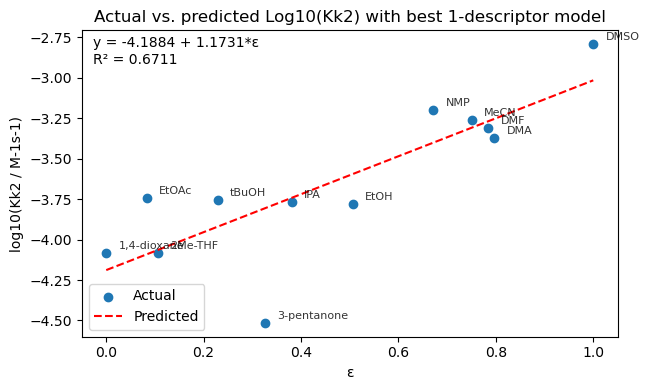

Regression Coefficients:
ε: 1.1731
Intercept: -4.1884
R²: 0.6711


In [15]:
model, r2 = run_linear_regression(
    data_C4,
    descriptors=['ε'],      
    output_var='Kk2 / M-1s-1',   
    log_output=True,              
    figsize=(6.6, 4),               
    annotation_datapoint_separation=0.5,
    normalize=True,
    annotate_equation=True,
    title='Actual vs. predicted Log10(Kk2) with best 1-descriptor model'
)

#### Best 2-descriptor model for Kk2

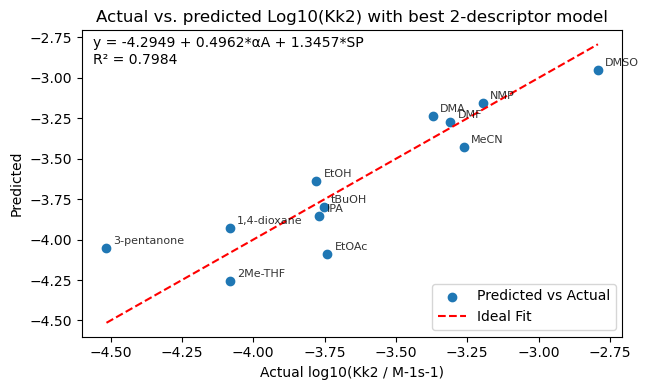

Regression Coefficients:
αA: 0.4962
SP: 1.3457
Intercept: -4.2949
R²: 0.7984


In [16]:
model, r2 = run_linear_regression(
    data_C4,
    descriptors=['αA', 'SP'],      
    output_var='Kk2 / M-1s-1',   
    log_output=True,              
    figsize=(6.6, 4),               
    annotation_datapoint_separation=0.5,
    normalize=True,
    annotate_equation=True,
    title='Actual vs. predicted Log10(Kk2) with best 2-descriptor model'
)

#### Best 3-descriptor model for Kk2

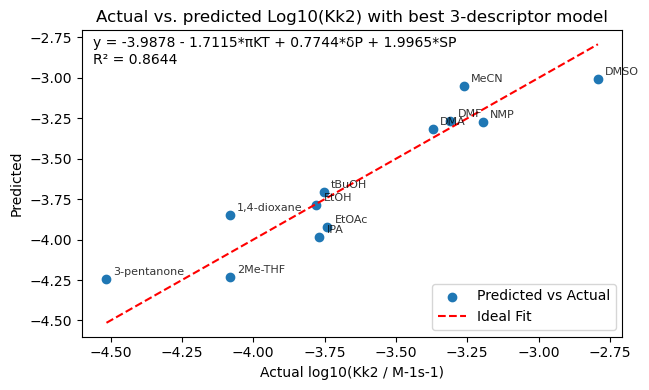

Regression Coefficients:
πKT: -1.7115
δP: 0.7744
SP: 1.9965
Intercept: -3.9878
R²: 0.8644


In [17]:
model, r2 = run_linear_regression(
    data_C4,
    descriptors=['πKT','δP', 'SP'],      
    output_var='Kk2 / M-1s-1',   
    log_output=True,              
    figsize=(6.6, 4),               
    annotation_datapoint_separation=0.5,
    normalize=True,
    annotate_equation=True,
    title='Actual vs. predicted Log10(Kk2) with best 3-descriptor model'
)

#### Best 4-descriptor model for Kk2

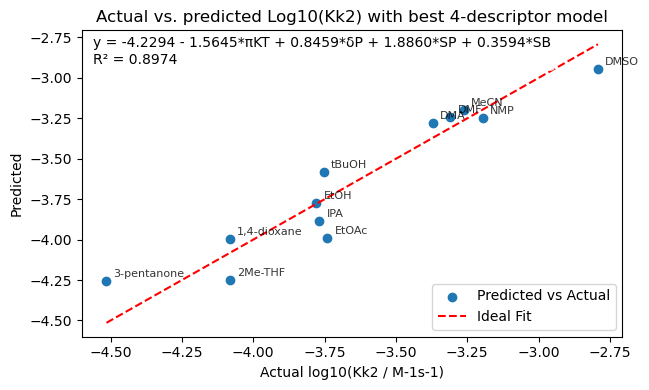

Regression Coefficients:
πKT: -1.5645
δP: 0.8459
SP: 1.8860
SB: 0.3594
Intercept: -4.2294
R²: 0.8974


In [18]:
model, r2 = run_linear_regression(
    data_C4,
    descriptors=['πKT','δP', 'SP','SB'],      
    output_var='Kk2 / M-1s-1',   
    log_output=True,              
    figsize=(6.6, 4),               
    annotation_datapoint_separation=0.5,
    normalize=True,
    annotate_equation=True,
    title='Actual vs. predicted Log10(Kk2) with best 4-descriptor model' 
)

### Evaluation of models for Pathway B (Kk3) 

In [19]:
sorted_r2_results_Kk3 = evaluate_combinations_with_coeffs(
    data_C4,
    descriptors=descriptors,
    output_var="Kk3 / M-2s-1",
    log_output=True,
    normalize=True,
    limit_descriptor_number=4,
)

#### Visualisation of best models for different number of descriptors

In [20]:
sorted_r2_results_Kk3.head(25)

,Descriptors (tuple),Number of Descriptors,Intercept,R²,Descriptor 1,Descriptor 1 coefficient,Descriptor 2,Descriptor 2 coefficient,Descriptor 3,Descriptor 3 coefficient,Descriptor 4,Descriptor 4 coefficient
0,"(ε, βKT, SA, AN)",4,-3.003414,0.987611,ε,1.441469,βKT,-0.658994,SA,-2.262173,AN,1.662605
1,"(ε, SA, AN, DN)",4,-3.031319,0.986814,ε,1.392781,SA,-2.965690,AN,2.084420,DN,-0.674311
2,"(αA, ε, βKT, SA)",4,-2.950555,0.975997,αA,0.920211,ε,1.895204,βKT,-0.738706,SA,-1.706039
3,"(αA, SA, δP, AN)",4,-3.152642,0.974976,αA,-1.124505,SA,-1.928796,δP,0.963527,AN,2.440947
4,"(γ , ET, βKT, SA)",4,-3.123195,0.973728,γ,0.392146,ET,2.802953,βKT,-0.414695,SA,-2.776122
5,"(ε, SB, SA, AN)",4,-2.786586,0.973068,ε,1.151079,SB,-0.692115,SA,-2.248663,AN,1.537446
6,"(ε, ET, βKT, SA)",4,-2.988624,0.972714,ε,0.761991,ET,1.731203,βKT,-0.477264,SA,-2.096885
7,"(ε, αKT, βKT, SA)",4,-2.961742,0.972612,ε,1.782290,αKT,1.349881,βKT,-0.486703,SA,-2.281455
8,"(βA, γ , ET, SA)",4,-3.087968,0.970161,βA,-0.486788,γ,0.755731,ET,2.496134,SA,-2.704105
9,"(ε, βKT, πKT, SA)",4,-2.732735,0.968481,ε,2.399832,βKT,-0.533402,πKT,-0.928746,SA,-1.191202


In [21]:
filter_models_by_n(sorted_r2_results_Kk3,1).head(10)

,Descriptors (tuple),Number of Descriptors,Intercept,R²,Descriptor 1,Descriptor 1 coefficient,Descriptor 2,Descriptor 2 coefficient,Descriptor 3,Descriptor 3 coefficient,Descriptor 4,Descriptor 4 coefficient
0,"(δP,)",1,-3.305955,0.734389,δP,1.619371,NaN,NaN,NaN,NaN,NaN,NaN
1,"(μ,)",1,-3.352682,0.727583,μ,1.422301,NaN,NaN,NaN,NaN,NaN,NaN
2,"(πKT,)",1,-3.253583,0.719029,πKT,1.490828,NaN,NaN,NaN,NaN,NaN,NaN
3,"(SP,)",1,-3.069593,0.671594,SP,1.301560,NaN,NaN,NaN,NaN,NaN,NaN
4,"(ε,)",1,-3.173886,0.562691,ε,1.327459,NaN,NaN,NaN,NaN,NaN,NaN
5,"(γ ,)",1,-3.051316,0.485911,γ,1.391622,NaN,NaN,NaN,NaN,NaN,NaN
6,"(SPP,)",1,-3.213595,0.473180,SPP,1.211083,NaN,NaN,NaN,NaN,NaN,NaN
7,"(αA,)",1,-2.334824,0.381773,αA,-0.885775,NaN,NaN,NaN,NaN,NaN,NaN
8,"(αKT,)",1,-2.352948,0.335636,αKT,-0.913229,NaN,NaN,NaN,NaN,NaN,NaN
9,"(SA,)",1,-2.345564,0.280112,SA,-0.958683,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
filter_models_by_n(sorted_r2_results_Kk3,2).head(10)

,Descriptors (tuple),Number of Descriptors,Intercept,R²,Descriptor 1,Descriptor 1 coefficient,Descriptor 2,Descriptor 2 coefficient,Descriptor 3,Descriptor 3 coefficient,Descriptor 4,Descriptor 4 coefficient
0,"(SA, δP)",2,-3.093529,0.941688,SA,-0.827963,δP,1.543036,NaN,NaN,NaN,NaN
1,"(αKT, δP)",2,-3.086658,0.922972,αKT,-0.695561,δP,1.471514,NaN,NaN,NaN,NaN
2,"(ET, SA)",2,-3.087457,0.915514,ET,2.793174,SA,-3.181344,NaN,NaN,NaN,NaN
3,"(αA, δP)",2,-3.060862,0.914085,αA,-0.626145,δP,1.420531,NaN,NaN,NaN,NaN
4,"(ε, δH)",2,-2.789456,0.911530,ε,1.415043,δH,-1.129969,NaN,NaN,NaN,NaN
5,"(ET, δP)",2,-3.096585,0.908444,ET,-0.881485,δP,1.993416,NaN,NaN,NaN,NaN
6,"(δP, AN)",2,-3.065978,0.907852,δP,1.656490,AN,-0.749340,NaN,NaN,NaN,NaN
7,"(δP, δH)",2,-2.955900,0.906522,δP,1.513417,δH,-0.798176,NaN,NaN,NaN,NaN
8,"(ε, SA)",2,-2.979823,0.894197,ε,1.389310,SA,-1.044850,NaN,NaN,NaN,NaN
9,"(μ, βKT)",2,-3.139783,0.855621,μ,1.558013,βKT,-0.611692,NaN,NaN,NaN,NaN


In [23]:
filter_models_by_n(sorted_r2_results_Kk3,3).head(10)

,Descriptors (tuple),Number of Descriptors,Intercept,R²,Descriptor 1,Descriptor 1 coefficient,Descriptor 2,Descriptor 2 coefficient,Descriptor 3,Descriptor 3 coefficient,Descriptor 4,Descriptor 4 coefficient
0,"(ET, SA, δP)",3,-3.117716,0.955060,ET,1.077055,SA,-1.730797,δP,1.002765,NaN,NaN
1,"(βA, ε, SA)",3,-2.795763,0.952575,βA,-0.568683,ε,1.651831,SA,-1.148798,NaN,NaN
2,"(SA, δP, AN)",3,-3.145506,0.952203,SA,-1.568678,δP,1.437309,AN,0.755715,NaN,NaN
3,"(ET, βKT, SA)",3,-3.024925,0.950193,ET,3.088835,βKT,-0.408931,SA,-3.171000,NaN,NaN
4,"(ET, SB, SA)",3,-2.869231,0.946790,ET,2.721004,SB,-0.467835,SA,-2.941327,NaN,NaN
5,"(ε, SA, δP)",3,-3.084297,0.945590,ε,0.315860,SA,-0.874368,δP,1.226511,NaN,NaN
6,"(γ , SA, δP)",3,-3.125392,0.944605,γ,0.148292,SA,-0.772050,δP,1.471317,NaN,NaN
7,"(SPP, SA, δP)",3,-3.109969,0.943692,SPP,0.136493,SA,-0.838670,δP,1.422963,NaN,NaN
8,"(αKT, SA, δP)",3,-3.102214,0.943218,αKT,0.273762,SA,-1.130527,δP,1.573334,NaN,NaN
9,"(βKT, SA, δP)",3,-3.080112,0.942429,βKT,-0.055929,SA,-0.793343,δP,1.555157,NaN,NaN


#### Best 1-descriptor model for Kk3

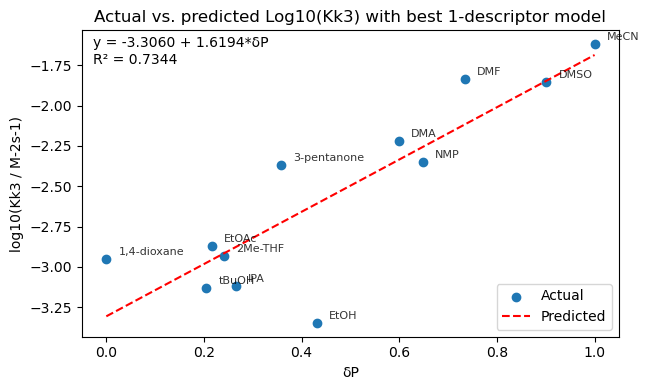

Regression Coefficients:
δP: 1.6194
Intercept: -3.3060
R²: 0.7344


In [24]:
model, r2 = run_linear_regression(
    data_C4,
    descriptors=['δP'],      
    output_var='Kk3 / M-2s-1',   
    log_output=True,              
    figsize=(6.6, 4),               
    annotation_datapoint_separation=0.5,
    normalize=True,
    annotate_equation=True,
    title='Actual vs. predicted Log10(Kk3) with best 1-descriptor model'
)

#### Best 2-descriptor model for Kk3

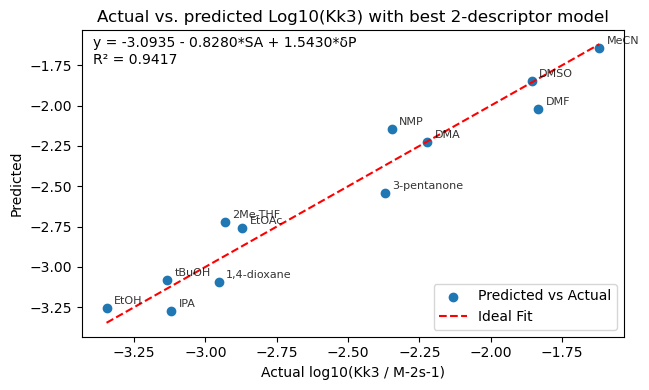

Regression Coefficients:
SA: -0.8280
δP: 1.5430
Intercept: -3.0935
R²: 0.9417


In [25]:
model, r2 = run_linear_regression(
    data_C4,
    descriptors=['SA', 'δP'],      
    output_var='Kk3 / M-2s-1',   
    log_output=True,              
    figsize=(6.6, 4),               
    annotation_datapoint_separation=0.5,
    normalize=True,
    annotate_equation=True,
    title='Actual vs. predicted Log10(Kk3) with best 2-descriptor model'
)

#### Best 3-descriptor model for Kk3

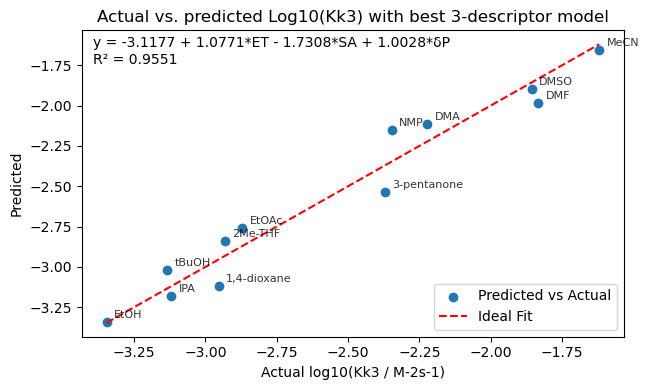

Regression Coefficients:
ET: 1.0771
SA: -1.7308
δP: 1.0028
Intercept: -3.1177
R²: 0.9551


In [26]:
# Run a regression
model, r2 = run_linear_regression(
    data_C4,
    descriptors=['ET', 'SA', 'δP']	,      
    output_var='Kk3 / M-2s-1',   
    log_output=True,              
    figsize=(6.6, 4),               
    annotation_datapoint_separation=0.5,
    normalize=True,
    annotate_equation=True,
    title='Actual vs. predicted Log10(Kk3) with best 3-descriptor model'
    
)

#### Best 4-descriptor model for Kk3

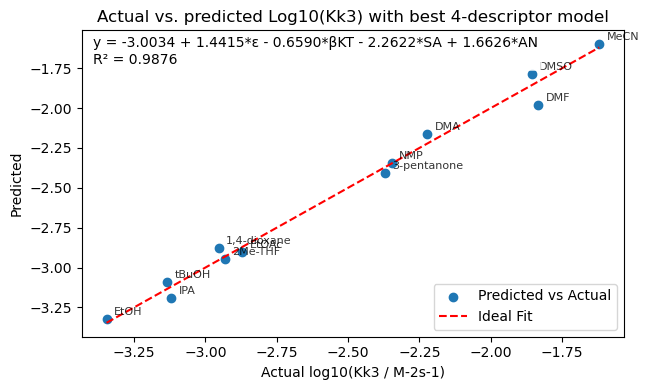

Regression Coefficients:
ε: 1.4415
βKT: -0.6590
SA: -2.2622
AN: 1.6626
Intercept: -3.0034
R²: 0.9876


In [27]:
# Run a regression
model, r2 = run_linear_regression(
    data_C4,
    descriptors=['ε', 'βKT', 'SA', 'AN'],      
    output_var='Kk3 / M-2s-1',   
    log_output=True,              
    figsize=(6.6, 4),               
    annotation_datapoint_separation=0.5,
    normalize=True,
    annotate_equation=True,
    title='Actual vs. predicted Log10(Kk3) with best 4-descriptor model'
    
)

### Clustering and Pearson Corrlation Matrix

In [28]:
def cluster_descriptors_and_corr_heatmap(
    df: pd.DataFrame,
    exclude: List[str],
    descriptors: Optional[List[str]] = None,
    n_components: Optional[int] = None,
    cluster_method: Literal["hclust", "kmeans", "none"] = "kmeans",  
    n_clusters: int = 3,
    linkage_method: Literal["ward", "average", "complete", "single"] = "average",
    metric: str = "euclidean",
    plot: bool = True,
    save_dir: Optional[str] = None,

    # Heatmap options (descriptor–descriptor correlation)
    annotate: bool = True,               # write r values in cells
    mask_upper: bool = True,             # hide mirrored upper triangle
    hide_diagonal: bool = True,          # hide r=1 diagonal
    masked_color: str = "#f0f0f0",       # color of masked cells
    cmap: str = "coolwarm",              # colormap for heatmap
) -> Dict[str, Any]:
    """
    Analyze descriptors only: PCA + clustering where *each descriptor is a sample*
    (its profile across the dataset rows), and plot a clustered descriptor–descriptor
    Pearson correlation heatmap.

    Inputs of note:
      - df: tidy numeric DataFrame (trusted: no NaNs).
      - exclude: columns to drop from consideration.
      - descriptors: optional explicit list of descriptor columns (else: all numeric not in exclude).
      - cluster_method: "kmeans" (default), "hclust", or "none".
      - For "hclust": relies on `metric` (e.g., Euclidean) and `linkage_method`.
      - Heatmap ordering:
          * If hclust performed: uses dendrogram leaf order (built on standardized profiles M_std).
          * Else: builds an order from Pearson correlations via 1 - |r| + optimal leaf ordering.

    Steps:
      1) Select descriptor columns.
      2) Build matrix X (n_rows x n_descriptors) → transpose to (n_descriptors x n_rows).
      3) Z-score each descriptor across rows -> M_std.
      4) PCA on descriptors (samples = descriptors, features = dataset rows).
      5) Cluster descriptors (k-means by default; hclust optional).
      6) Plot scree, PCA scatter, (optional) dendrogram, and clustered Pearson correlation heatmap.

    Returns a dict of artifacts (scores, clusters, correlation matrix, etc.).
    """

    # ----- 1) Select descriptors (numeric, excluding requested columns) -----
    if descriptors is None:
        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        descriptors = [c for c in numeric_cols if c not in exclude]

    if len(descriptors) == 0:
        raise ValueError("No descriptor columns available after applying 'exclude' and/or 'descriptors'.")

    # ----- 2) Build descriptor x row matrix -----
    # DataFrame shape: (n_rows, n_descriptors). We want (n_descriptors, n_rows)
    X = df[descriptors].to_numpy(dtype=float).T
    desc_names = descriptors

    # ----- 3) Z-score per descriptor (no NaN handling; trust input) -----
    X_mean = X.mean(axis=1, keepdims=True)
    X_std = X.std(axis=1, ddof=0, keepdims=True)
    eps = 1e-12  # numerical stability if a descriptor is constant
    M_std = (X - X_mean) / (X_std + eps)  # (n_desc, n_rows)

    # ----- 4) PCA on descriptors (samples = descriptors, features = dataset rows) -----
    pca = PCA(n_components=n_components)
    Z = pca.fit_transform(M_std)  # shape: (n_desc, n_components_kept)
    comp_labels = [f"PC{i+1}" for i in range(pca.n_components_)]
    scores = pd.DataFrame(Z, index=desc_names, columns=comp_labels)
    evr = pca.explained_variance_ratio_
    explained_variance = pd.DataFrame(
        {"PC": comp_labels, "ExplainedVarianceRatio": evr, "Cumulative": np.cumsum(evr)}
    )

    # ----- 5) Clustering of descriptors -----
    labels = None
    linkage_mat = None

    if cluster_method == "kmeans":
        km = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
        labels = km.fit_predict(Z)

    elif cluster_method == "hclust":
        # Pairwise distance between descriptor profiles (on M_std)
        dist_metric = "euclidean" if linkage_method == "ward" else metric
        D = pdist(M_std, metric=dist_metric)
        linkage_mat = linkage(D, method=linkage_method)

        # Optional discrete labels from Agglomerative on PCA scores (Z)
        try:
            agg = AgglomerativeClustering(
                n_clusters=n_clusters,
                metric="euclidean" if linkage_method == "ward" else metric,
                linkage=linkage_method,
            )
        except TypeError:
            # Backward-compat for older sklearn (use 'affinity')
            agg = AgglomerativeClustering(
                n_clusters=n_clusters,
                affinity="euclidean" if linkage_method == "ward" else metric,
                linkage=linkage_method,
            )
        labels = agg.fit_predict(Z)

    elif cluster_method == "none":
        pass
    else:
        raise ValueError("cluster_method must be 'hclust', 'kmeans', or 'none'.")

    # ----- 6) Save artifacts -----
    if save_dir:
        out = Path(save_dir)
        out.mkdir(parents=True, exist_ok=True)
        # z-scored descriptor profiles
        pd.DataFrame(M_std, index=desc_names, columns=[f"row_{i}" for i in range(M_std.shape[1])]).to_csv(
            out / "descriptor_profiles_zscored.csv"
        )
        scores.to_csv(out / "pca_scores_descriptors.csv")
        explained_variance.to_csv(out / "pca_explained_variance.csv", index=False)
        if labels is not None:
            pd.Series(labels, index=desc_names, name="Cluster").to_csv(out / "descriptor_clusters.csv")

    # ----- 7) Plots -----
    if plot:
        # Publication-ready defaults
        plt.rcParams.update({
            "figure.dpi": 300,
            "font.size": 11,
            "axes.titlesize": 12,
            "axes.labelsize": 11,
            "xtick.labelsize": 9,
            "ytick.labelsize": 9,
            "legend.fontsize": 9,
        })

        # Scree
        plt.figure(figsize=(6, 4))
        plt.plot(range(1, len(evr) + 1), evr, marker="o")
        plt.xlabel("Principal Component")
        plt.ylabel("Explained variance ratio")
        plt.title("PCA Scree Plot (Descriptors)")
        plt.tight_layout()
        plt.show()

    # PCA scatter of descriptors (PC1 vs PC2)
    if pca.n_components_ >= 2:
        fig, ax = plt.subplots(figsize=(7.2, 5.0))

        if labels is not None:
            unique_labels = np.unique(labels)
            color_list = ["red", "blue", "green", "orange", "purple", "brown", "pink", "cyan"]
            for i, lab in enumerate(unique_labels):
                mask = labels == lab
                ax.scatter(
                    Z[mask, 0], Z[mask, 1],
                    s=50, alpha=0.9,
                    color=color_list[i % len(color_list)],
                    label=f"Cluster {lab}"
                )
            ax.legend(title="Cluster", frameon=False)
        else:
            ax.scatter(Z[:, 0], Z[:, 1], s=50, alpha=0.9, color="grey")

        # annotate points with names
        for i, name in enumerate(desc_names):
            ax.text(Z[i, 0], Z[i, 1], name, fontsize=8, ha="left", va="bottom")

        ax.set_xlabel(f"PC1 ({evr[0]*100:.1f}%)")
        ax.set_ylabel(f"PC2 ({evr[1]*100:.1f}%)")
        ax.set_title("Descriptors PCA (each descriptor is a point)")
        ax.spines[['top', 'right']].set_visible(False)
        plt.tight_layout()
        plt.show()

        # Dendrogram (hierarchical) — only if hclust was run
        if linkage_mat is not None:
            plt.figure(figsize=(8.5, 5.0))
            dendrogram(linkage_mat, labels=desc_names, leaf_rotation=90, color_threshold=0.4)
            plt.title("Descriptor Dendrogram")
            plt.tight_layout()
            plt.show()

        # === Clustered descriptor–descriptor correlation heatmap ===
        # Pearson correlations among descriptors (across rows).
        corr_dd = np.corrcoef(M_std)  # (n_desc, n_desc)

        # --- Build an ordering for the heatmap ---
        if linkage_mat is not None:
            # if you did hclust earlier on M_std, reuse that ordering
            order = leaves_list(linkage_mat)
        else:
            # build a correlation-based dendrogram just for ordering
            dist = 1 - np.abs(corr_dd)
            np.fill_diagonal(dist, 0.0)
            Z_ord = linkage(squareform(dist, checks=False), method="average")
            Z_ord = optimal_leaf_ordering(Z_ord, squareform(dist, checks=False))
            order = leaves_list(Z_ord)

        corr_ord = corr_dd[np.ix_(order, order)]
        labels_ord = [desc_names[i] for i in order]

        # Mask to hide mirrored half / diagonal
        n = len(labels_ord)
        mask = np.zeros((n, n), dtype=bool)
        if mask_upper:
            k = 0 if hide_diagonal else 1
            mask |= np.triu(np.ones((n, n), dtype=bool), k=k)
        data_to_plot = np.ma.masked_where(mask, corr_ord)

        cmap_obj = plt.get_cmap("coolwarm")
        cmap_obj.set_bad(color=masked_color)

        plt.figure(figsize=(0.42 * n + 2, 0.42 * n + 2))
        im = plt.imshow(data_to_plot, vmin=-1, vmax=1, cmap=cmap_obj, aspect="equal", interpolation="nearest")
        plt.xticks(range(n), labels_ord, rotation=90)
        plt.yticks(range(n), labels_ord)
        cbar = plt.colorbar(im, shrink=0.85, pad=0.02)
        cbar.set_label("Pearson r (descriptor–descriptor)")

        if annotate:
            # 2-decimal annotations with automatic contrast for readability
            for i in range(n):
                for j in range(n):
                    if mask[i, j]:
                        continue
                    val = corr_ord[i, j]
                    rgba = im.cmap(im.norm(val))
                    Y = 0.2126 * rgba[0] + 0.7152 * rgba[1] + 0.0722 * rgba[2]
                    txt_color = "black" if Y > 0.5 else "white"
                    plt.text(j, i, f"{val:.2f}", ha="center", va="center", fontsize=7.5, color=txt_color)

        plt.title("Clustered Heatmap: Descriptor–Descriptor Correlation")
        plt.tight_layout()
        plt.show()

    # Package outputs
    corr_df = pd.DataFrame(np.corrcoef(M_std), index=desc_names, columns=desc_names)
    labels_series = pd.Series(labels, index=desc_names, name="Cluster") if labels is not None else None

    return {
        "descriptor_names": desc_names,
        "profiles_z": pd.DataFrame(M_std, index=desc_names, columns=[f"row_{i}" for i in range(M_std.shape[1])]),
        "pca": pca,
        "scores_descriptors": scores,
        "explained_variance": explained_variance,
        "labels_descriptors": labels_series,
        "linkage": linkage_mat,
        "corr_descriptors": corr_df,        
        "corr_descriptors_order": labels_ord,}

In [29]:
def pearson_correlations(
    df: pd.DataFrame,
    outputs: Optional[List[str]] = None,
    descriptors: Optional[List[str]] = None,
    solvent_col: str = "Solvent",
    save_dir: Optional[str] = None,
    plot_heatmap: bool = True,
    annotate_cells: bool = True,
    transpose: bool = False,
    figsize: Optional[Tuple[float, float]] = None,
    two_line_labels: bool = False,
    descriptor_order: Optional[List[str]] = None,
    cbar_shrink: float = 0.8,                   
) -> Dict[str, Any]:
    """
    Compute Pearson correlations between solvent descriptors and kinetic outputs.

    Parameters
    ----------
    df : pd.DataFrame
        Dataframe with outputs and inputs
    outputs : list[str] or None
        Output (Y) columns. If None, defaults to typical kinetic columns.
    descriptors : list[str] or None
        Descriptor (X) columns. If None, auto-detects as all numeric columns
        except outputs (and solvent_col).
    solvent_col : str
        Name of the solvent identifier column (won't be coerced to numeric).
    save_dir : str or None
        If provided, CSVs and heatmap PNG will be saved here.
    plot_heatmap : bool
        If True, show a correlation heatmap.
    annotate_cells : bool
        If True, put r-values as text in the heatmap cells.
    transpose : bool
        If True, plot outputs on Y-axis and descriptors on X-axis.
    figsize : tuple(float, float) or None
        Manually set figure size. If None, use automatic scaling.
    two_line_labels : bool
        If True, replace " / " with a line break in output labels.

    Returns
    -------
    results : dict
        {
          "tidy": tidy DataFrame with columns [output, descriptor, n, r, p, abs_r],
          "r_matrix": wide DataFrame (descriptors x outputs) of r,
          "p_matrix": wide DataFrame (descriptors x outputs) of p
        }
    """
    if outputs is None:
        outputs = [
            "Kk2 / M-1s-1",
            "Kk3 / M-2s-1",
            "k3/k2",
            "KI",
        ]

    # Make a numeric copy (except solvent name)
    df_num = df.copy()
    for col in df_num.columns:
        if col != solvent_col:
            df_num[col] = pd.to_numeric(df_num[col], errors="coerce")

    # Decide descriptors
    if descriptors is None:
        numeric_cols = df_num.select_dtypes(include=[np.number]).columns.tolist()
        descriptors = [c for c in numeric_cols if c not in outputs]

    # Keep only outputs that actually exist
    outputs = [c for c in outputs if c in df_num.columns]

    # Calculate Pearson r and p
    rows = []
    for y in outputs:
        for x in descriptors:
            sub = df_num[[x, y]].dropna()
            n = len(sub)
            if n >= 3:
                r, p = pearsonr(sub[x], sub[y])
            else:
                r, p = (np.nan, np.nan)
            rows.append({
                "output": y,
                "descriptor": x,
                "n": n,
                "r": r,
                "p": p,
                "abs_r": abs(r) if pd.notna(r) else np.nan
            })

    tidy = pd.DataFrame(rows).sort_values(["output", "abs_r"], ascending=[True, False])

    # Wide matrices
    r_matrix = tidy.pivot(index="descriptor", columns="output", values="r")
    p_matrix = tidy.pivot(index="descriptor", columns="output", values="p")

    # Optional save
    if save_dir is not None:
        out = Path(save_dir)
        out.mkdir(parents=True, exist_ok=True)
        tidy.to_csv(out / "pearson_correlations_tidy.csv", index=False)
        r_matrix.to_csv(out / "pearson_r_matrix.csv")
        p_matrix.to_csv(out / "pearson_p_matrix.csv")

    # Optional heatmap
    if plot_heatmap and len(outputs) > 0 and len(descriptors) > 0:
        # Order descriptors by mean |r| (strongest overall first)
        if descriptor_order is not None:
            order = [d for d in descriptor_order if d in r_matrix.index]
        else:
            order = tidy.groupby("descriptor")["abs_r"].mean().sort_values(ascending=False).index
        r_plot = r_matrix.loc[order, outputs]

        # Apply label formatting
        output_labels = outputs
        if two_line_labels:
            output_labels = [lbl.replace(" / ", "\n") for lbl in outputs]

        # Handle transpose
        if transpose:
            r_plot_to_show = r_plot.T
            x_labels = order
            y_labels = output_labels
        else:
            r_plot_to_show = r_plot
            x_labels = output_labels
            y_labels = order

        # Figure size
        if figsize is None:
            fig_w = 0.4 * len(x_labels) + 2
            fig_h = 0.4 * len(y_labels) + 2
            figsize_use = (fig_w, fig_h)
            print(figsize_use)
        else:
            figsize_use = figsize

        fig, ax = plt.subplots(figsize=figsize_use)

        # Use consistent diverging colormap [-1, 1]
        cmap_obj = plt.get_cmap("coolwarm")
        im = ax.imshow(r_plot_to_show.values, aspect="equal", vmin=-1, vmax=1, cmap=cmap_obj)

        ax.set_xticks(range(len(x_labels)))
        ax.set_xticklabels(x_labels, rotation=90)
        ax.set_yticks(range(len(y_labels)))
        ax.set_yticklabels(y_labels)
        ax.set_title("Pearson r: descriptors vs outputs")

        # Colorbar
        cbar = plt.colorbar(im, ax=ax, shrink=cbar_shrink,pad=0.02)
        cbar.set_label("Pearson r (descriptor–output)")

        if annotate_cells:
            for i in range(r_plot_to_show.shape[0]):
                for j in range(r_plot_to_show.shape[1]):
                    val = r_plot_to_show.values[i, j]
                    if np.isfinite(val):
                        ax.text(j, i, f"{val:.2f}", ha="center", va="center", fontsize=7)

        plt.tight_layout()
        if save_dir is not None:
            fig.savefig(Path(save_dir) / "pearson_r_heatmap.png", dpi=300)
        plt.show()

    return {"tidy": tidy, "r_matrix": r_matrix, "p_matrix": p_matrix}


C:\Users\test_gv\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\test_gv\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "C:\Users\test_gv\anaconda3\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\test_gv\anaconda3\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^

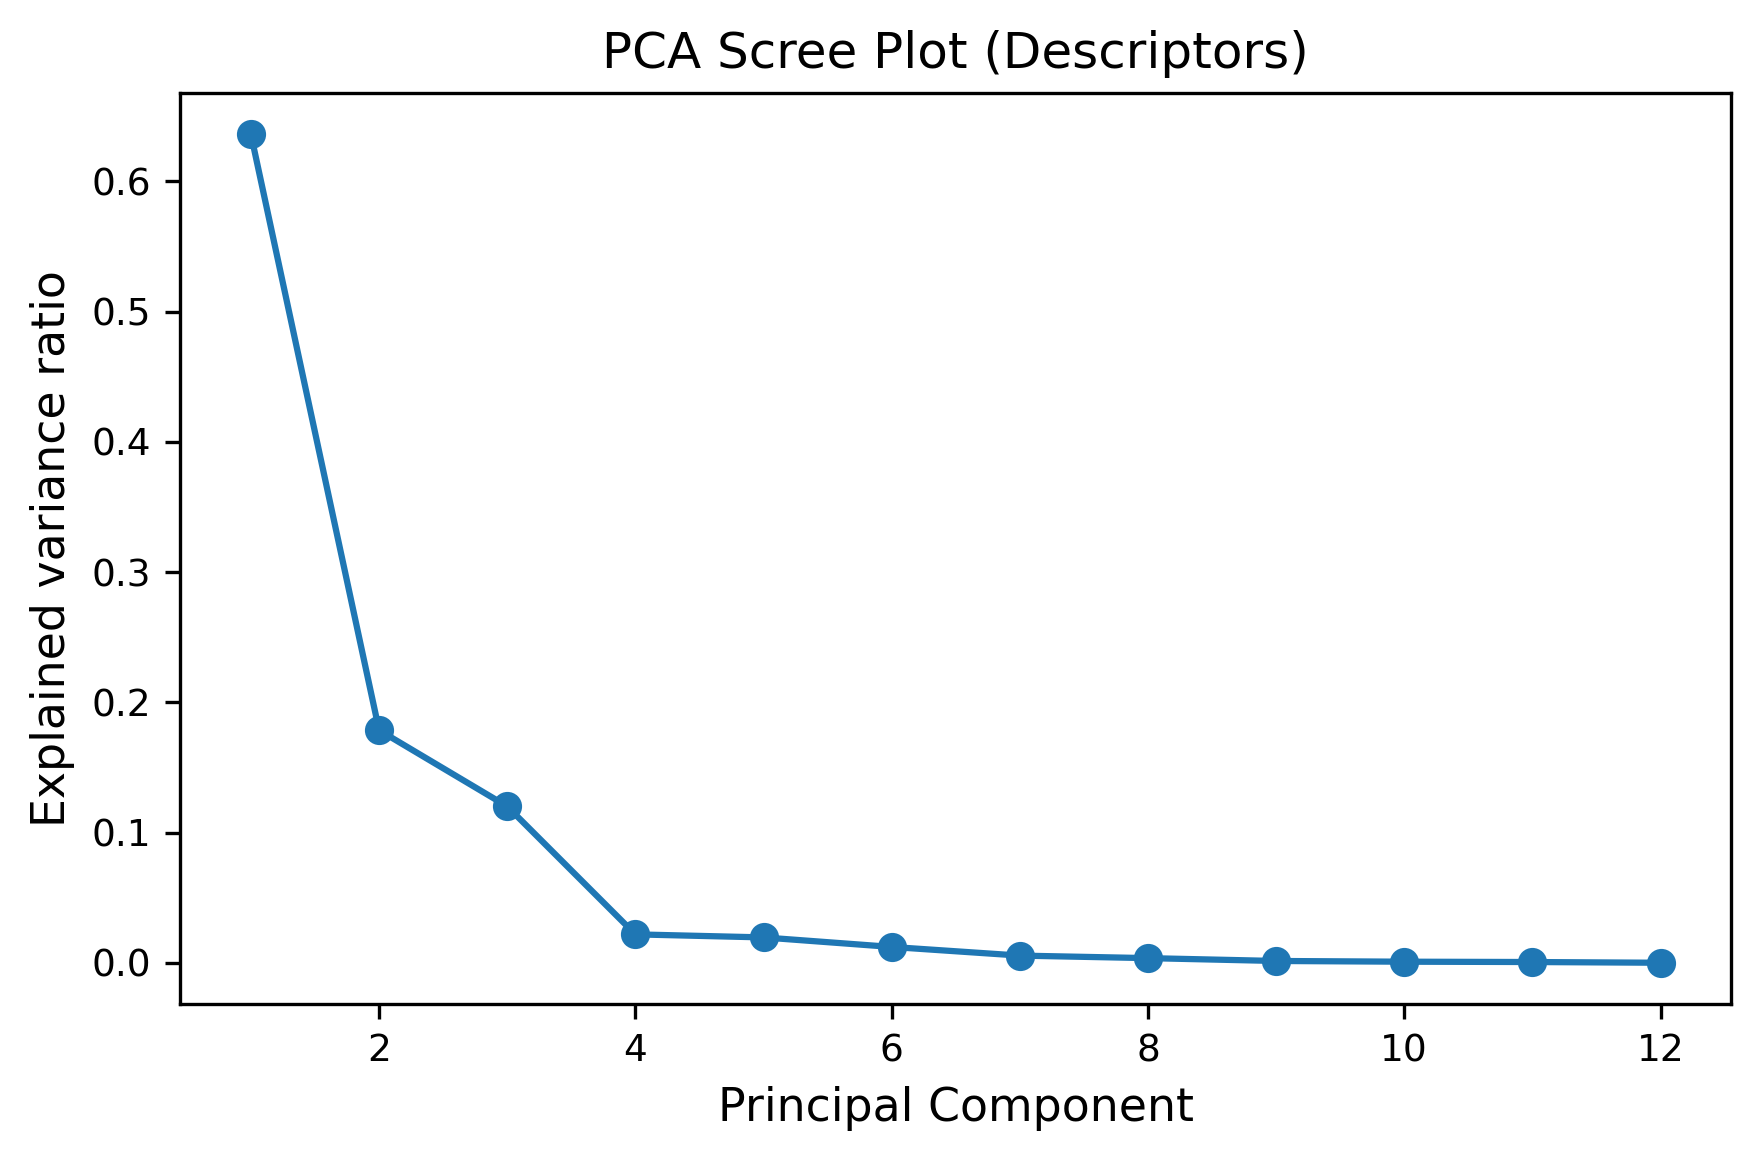

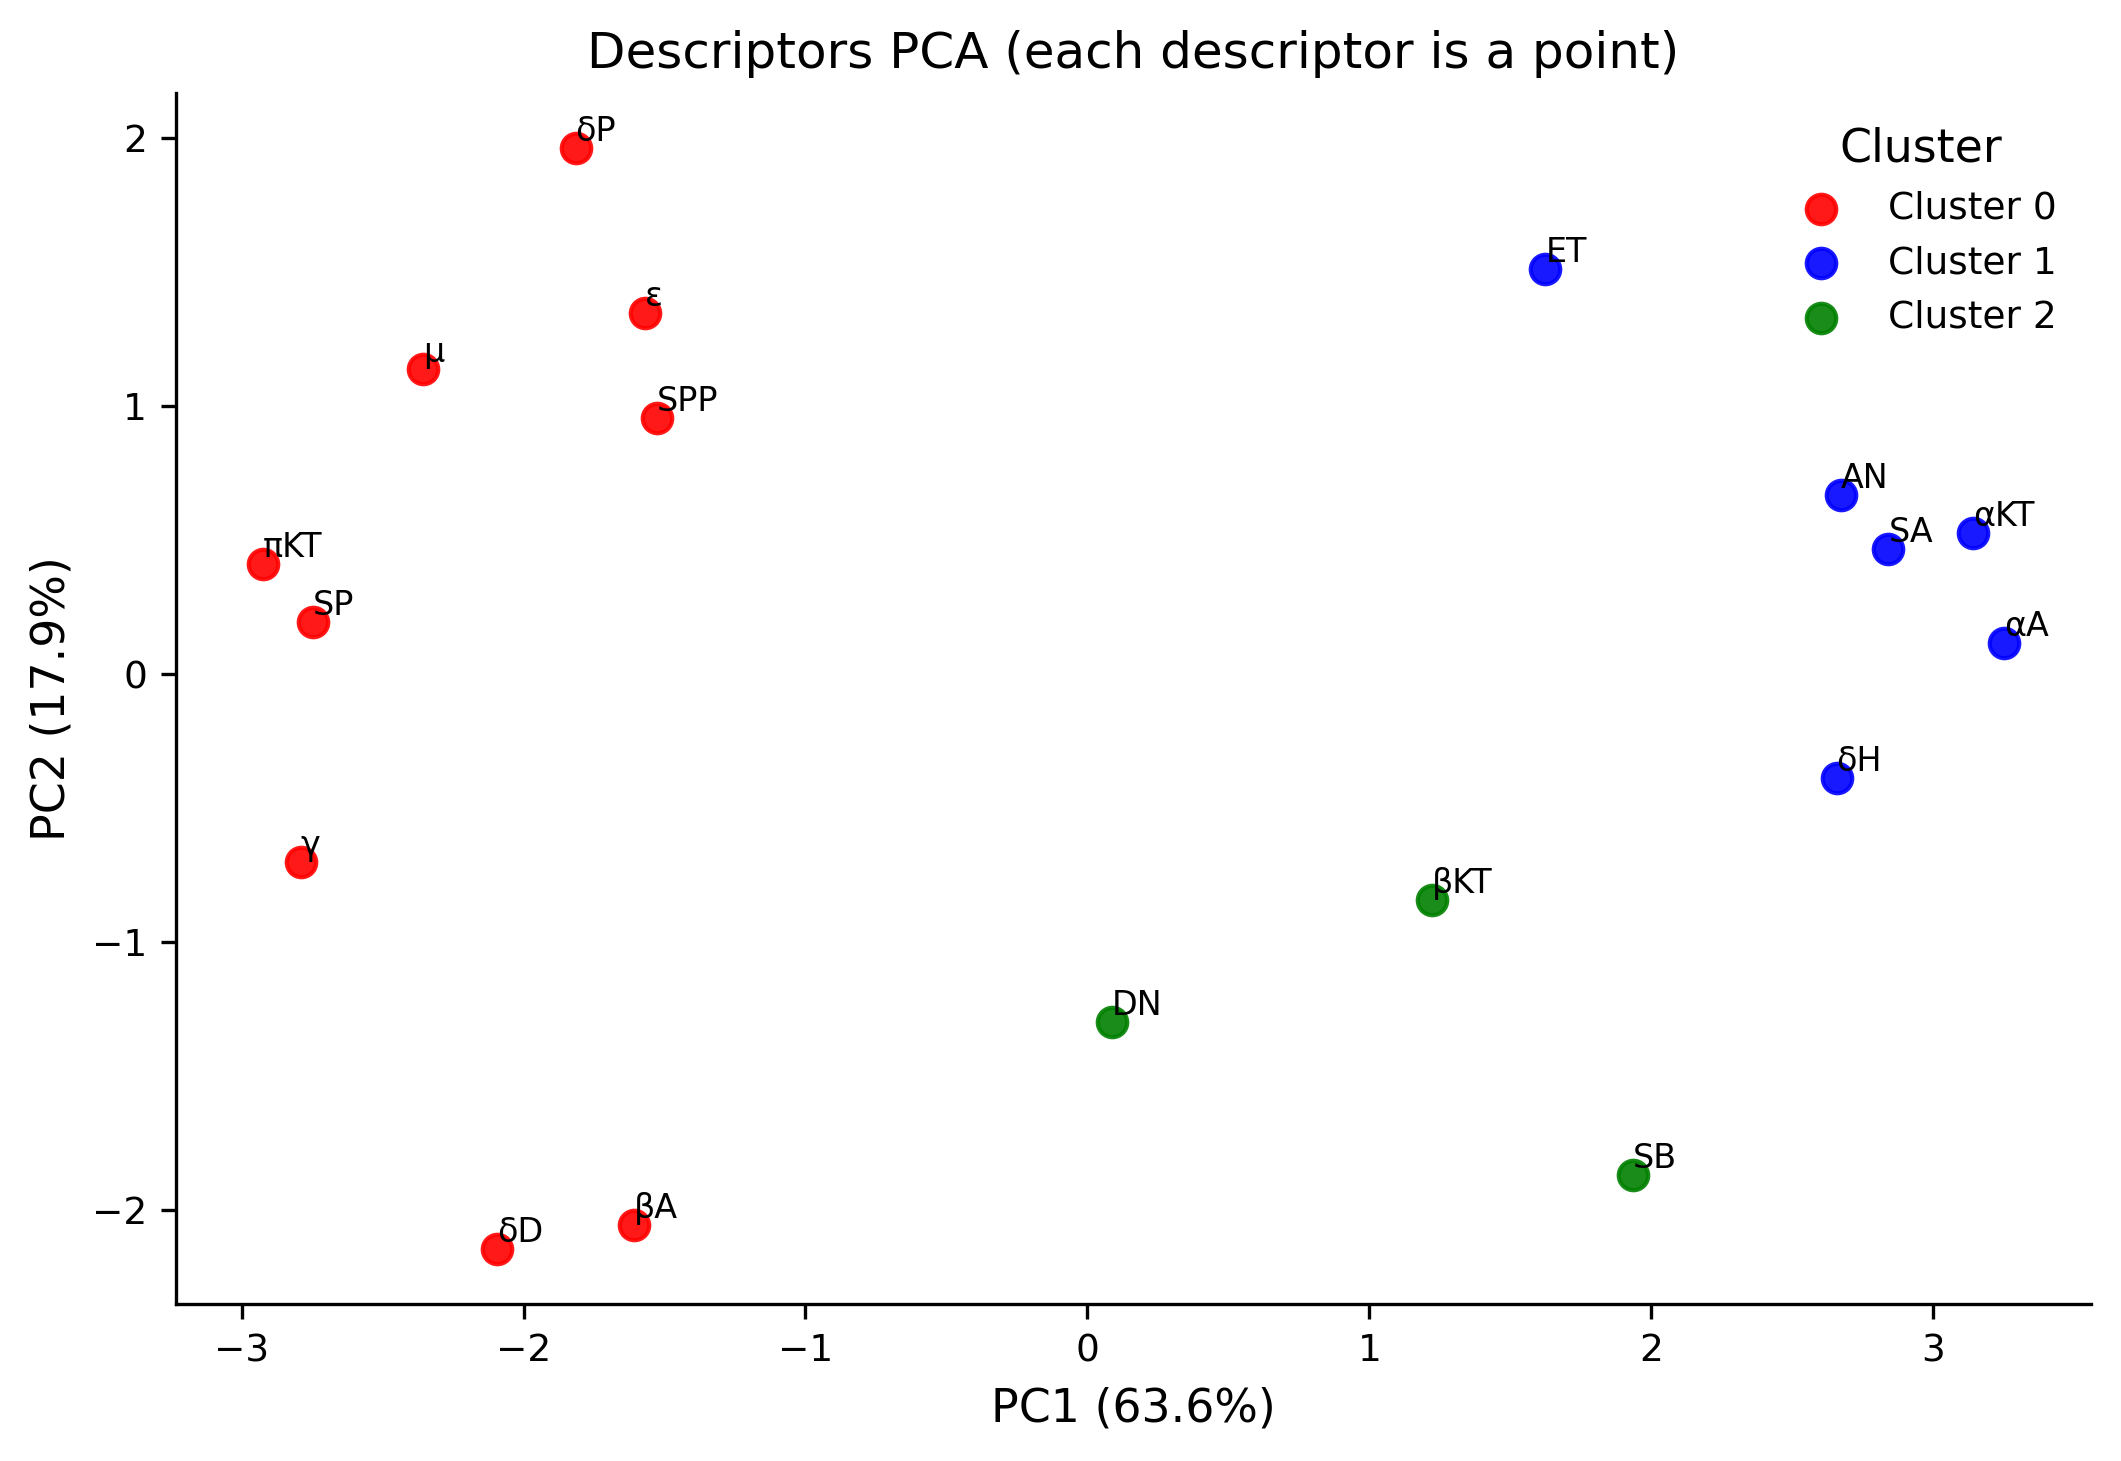

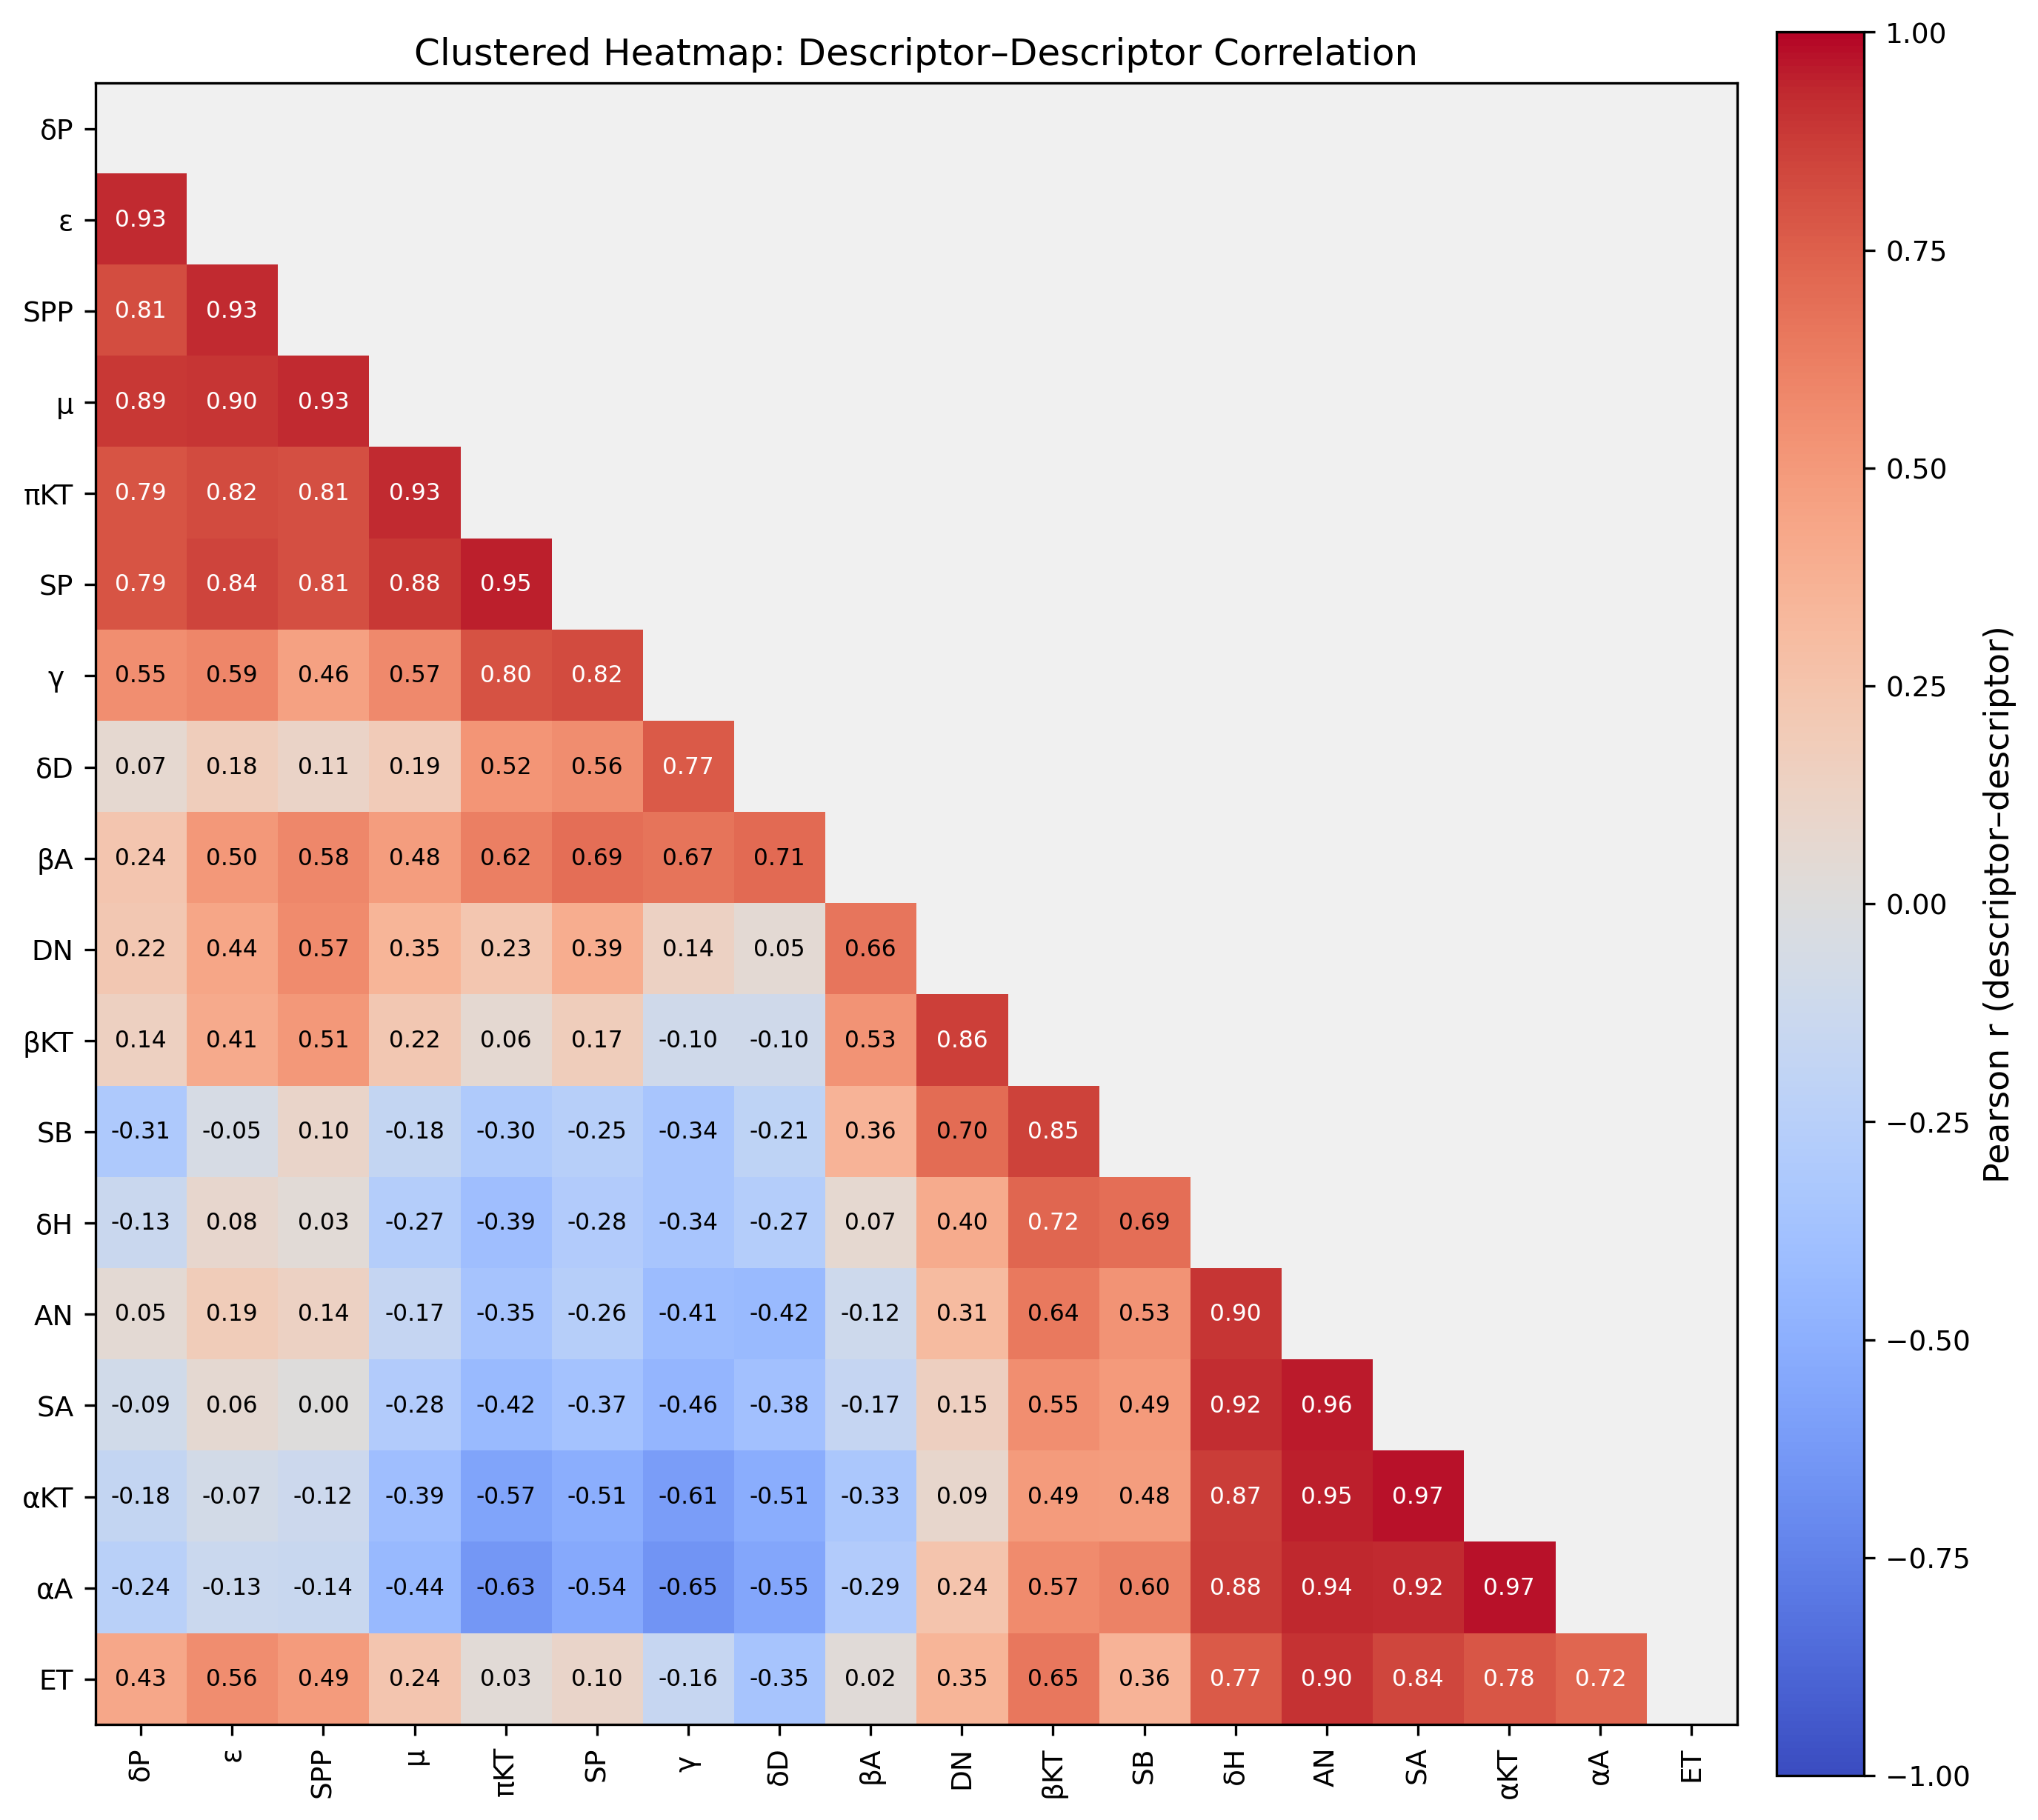

In [30]:
out = cluster_descriptors_and_corr_heatmap(
    data_C4,
    exclude=["Kk2 / M-1s-1","Kk3 / M-2s-1","k3/k2","KI","Solvent"],  
    plot=True,
    cluster_method="kmeans",
    linkage_method="average",
    metric="correlation",    
    annotate=True,
    mask_upper=True,
    hide_diagonal=True,
    masked_color="#f0f0f0",
    
)


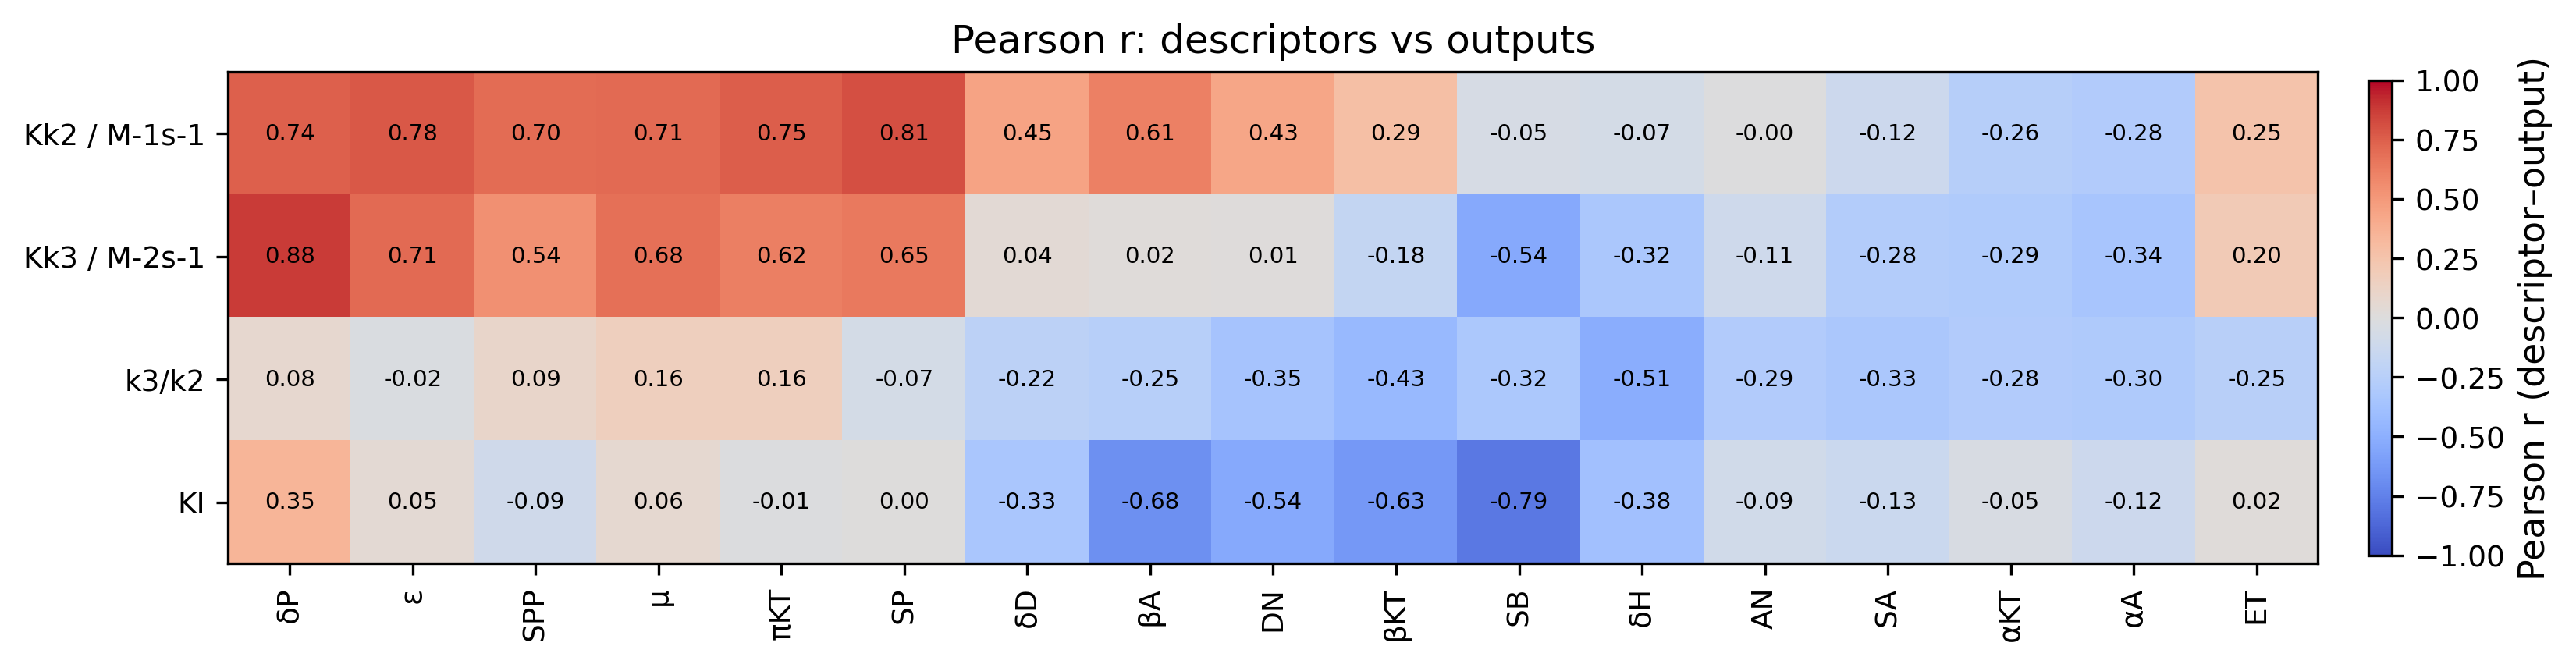

output,KI,Kk2 / M-1s-1,Kk3 / M-2s-1,k3/k2
descriptor,,,,
AN,0.785691,0.991608,0.738124,0.368535
DN,0.070541,0.159136,0.968515,0.262018
ET,0.957774,0.430124,0.530866,0.442371
SA,0.694688,0.713047,0.381090,0.299507
SB,0.002257,0.882377,0.072298,0.311079
SP,0.988265,0.001450,0.022566,0.831350
SPP,0.769073,0.011126,0.067944,0.770444
αA,0.707372,0.375519,0.279318,0.338623
αKT,0.887308,0.405492,0.355223,0.372310


In [31]:
res = pearson_correlations(data_C4, save_dir="correlation_results",transpose=True,figsize=(9.2*1.3, 3.6*1.5),cbar_shrink=0.4,descriptor_order=['δP', 'ε' ,'SPP', 'μ', 'πKT','SP','γ','δD', 'βA', 'DN', 'βKT', 'SB', 'δH','AN','SA','αKT', 'αA','ET'])

# Access tables:
res["tidy"].head(10)
res["r_matrix"]
res["p_matrix"]